## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb

## Importing data

In [2]:
runs_data = pd.read_csv("/kaggle/input/hkracing/runs.csv")

#removig unnessary columns
runs_data = runs_data[['result','horse_age', 'horse_country', 'horse_type', 'horse_rating',
          'declared_weight', 'actual_weight', 'draw','win_odds' ]] #'place_odds', 'trainer_id', 'jockey_id', 'horse_no', 'horse_id'

#runs_data = pd.get_dummies(runs_data)

In [3]:
#Validating data types
for col in runs_data.columns:
    print(col, "-->" , runs_data[col].dtype, " | " , runs_data[col].unique())

result --> int64  |  [10  8  7  9  6  3 12  1 13 14  2  4 11  5]
horse_age --> int64  |  [ 3  2  4  5  6  7  8  9 10]
horse_country --> object  |  ['AUS' 'NZ' 'SAF' 'GB' 'USA' 'IRE' 'FR' 'CAN' nan 'ARG' 'GER' 'ZIM' 'JPN'
 'BRZ' 'GR' 'ITY' 'SPA']
horse_type --> object  |  ['Gelding' 'Mare' 'Horse' 'Brown' 'Rig' 'Colt' nan 'Roan' 'Filly' 'Grey']
horse_rating --> int64  |  [ 60  52  80 100  79  77  75  73  70  68  49  63  58  59  50  71  48  65
  47  72  69  76  87  66  91  51  82  64  96  55  67  62 103  54 109  61
  86  84 122  85  57  53  43  56  41  40  46  78  81  89  38  45  39  83
  74  93  44  88  95  98 106 125  94  92  97 104  99  90 105 112 107  42
  37  36  33  35  34 108  32  28  23 111  31 116 113  30  18  27 118  24
  26 120 101 102 124  19  20 114 128  25 119  29 110  21 117 130 126 115
  22 121 129  16  17 133 123  15 134 132 127 131 138  13  10  11 136]
declared_weight --> float64  |  [1020.          980.         1082.         1118.          972.
 1114.          978.    

In [4]:
#Checking nulls
runs_data.isna().sum()

result             0
horse_age          0
horse_country      2
horse_type         2
horse_rating       0
declared_weight    0
actual_weight      0
draw               0
win_odds           0
dtype: int64

In [5]:
#Checking rows with null data
runs_data.loc[runs_data['horse_country'].isna()==True]

,result,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds
182,5,3,NaN,NaN,60,1107.0,120,12,28.0
846,11,3,NaN,NaN,60,1105.0,119,1,14.0


In [6]:
#Dropping rows with nulls as they do not contribute to correct class
runs_data.dropna(inplace=True, axis=0)

#Converting categorical data
runs_data = pd.get_dummies(runs_data)

### Creating data for training and testing

In [7]:
X = runs_data.drop("result", axis=1)
y = runs_data['result']

#This is to avoid labelling error with XGBOOST
le = LabelEncoder()
y = le.fit_transform(y)

#For binary classification task, using first 3 ranks as correct class to imporve inblance in comparison if used just 1st horse.
y = np.where(y<3, 1, 0)

X.head(10)

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90, stratify=y)

In [8]:
#Checking correct label distribution in both training and test datasets
for i in [y_test, y_train]:
    print( sum(i)/len(i))

0.2399773428157845
0.2400088111271949


## Getting Model

In [9]:
#Defining function to print out metrics
def model_metrics(model, X_data, y_data):
    y_preds = model.predict(X_data)
    print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, y_preds), 
          'f1_score: ', sklearn.metrics.f1_score(y_test, y_preds, average=None))
    print('confusion matrix: ', '\n', sklearn.metrics.confusion_matrix(y_test, y_preds))

### Running Hyperparameter Tuning for XGBoost Model 

In [10]:
#1st run {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 5.0, 'scale_pos_weight': 5}
#2nd run {'learning_rate': 0.1, 'scale_pos_weight': 5}

param_grid = {
    'learning_rate':[0.1,0.15],
    'scale_pos_weight':[5,6]
}

model = xgb.XGBClassifier(objective='binary:logistic', 
                          max_depth=2,
                          gamma=0.25,
                          reg_lambda=5,
                          subsample=0.9, 
                          colsample_bytree=0.5,
                          early_stopping_rounds=10,
                          eval_metric='auc'
                         )

optimal_params = sklearn.model_selection.GridSearchCV(estimator=model,
                             param_grid=param_grid,
                             scoring='roc_auc', cv=3, n_jobs=10)
optimal_params.fit(X_train, 
                   y_train,
                   eval_set=[(X_test, y_test)], verbose=0)
print(optimal_params.best_params_)

{'learning_rate': 0.1, 'scale_pos_weight': 5}


Accuracy:  0.5843665428913084 f1_score:  [0.64563211 0.49748897]
confusion matrix:  
 [[6016 6060]
 [ 544 3269]]


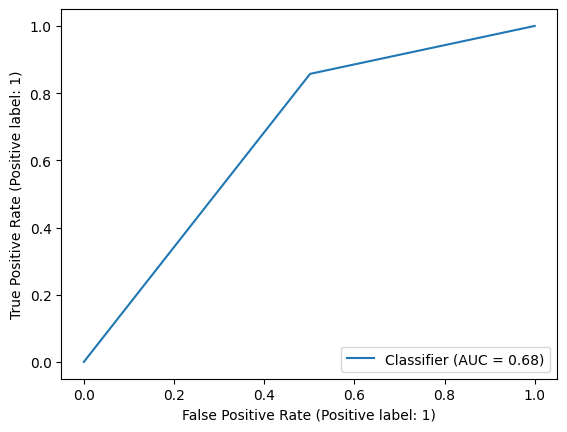

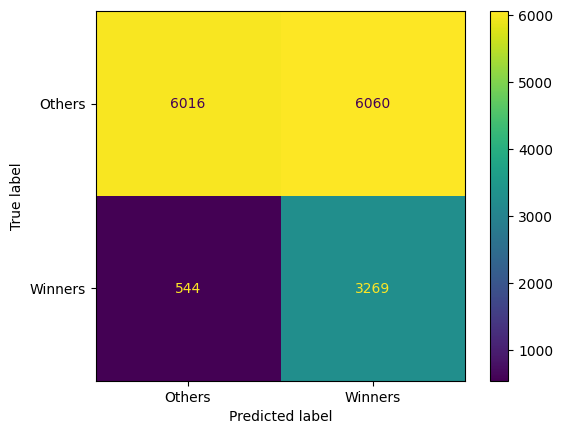

In [11]:
# Previous: confusion matrix:  
#  [[11515   561]
#  [ 2901   912]]

xg_model = model = xgb.XGBClassifier(objective='binary:logistic', 
                          max_depth=2,
                          learning_rate=0.1,
                          scale_pos_weight=5,       #adds weights to correct class and wrong class
                          gamma=0.25,
                          reg_lambda=5,
                          subsample=0.9, 
                          colsample_bytree=0.5,    #percentage of columns selected, helps with fit
                          early_stopping_rounds=10,
                          eval_metric='auc'
                         )
xg_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
y_preds = xg_model.predict(X_test)

model_metrics(xg_model, X_test, y_test)
sklearn.metrics.RocCurveDisplay.from_predictions(y_test, y_preds)
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(xg_model, X_test, y_test, display_labels=['Others', 'Winners'])

<Axes: >

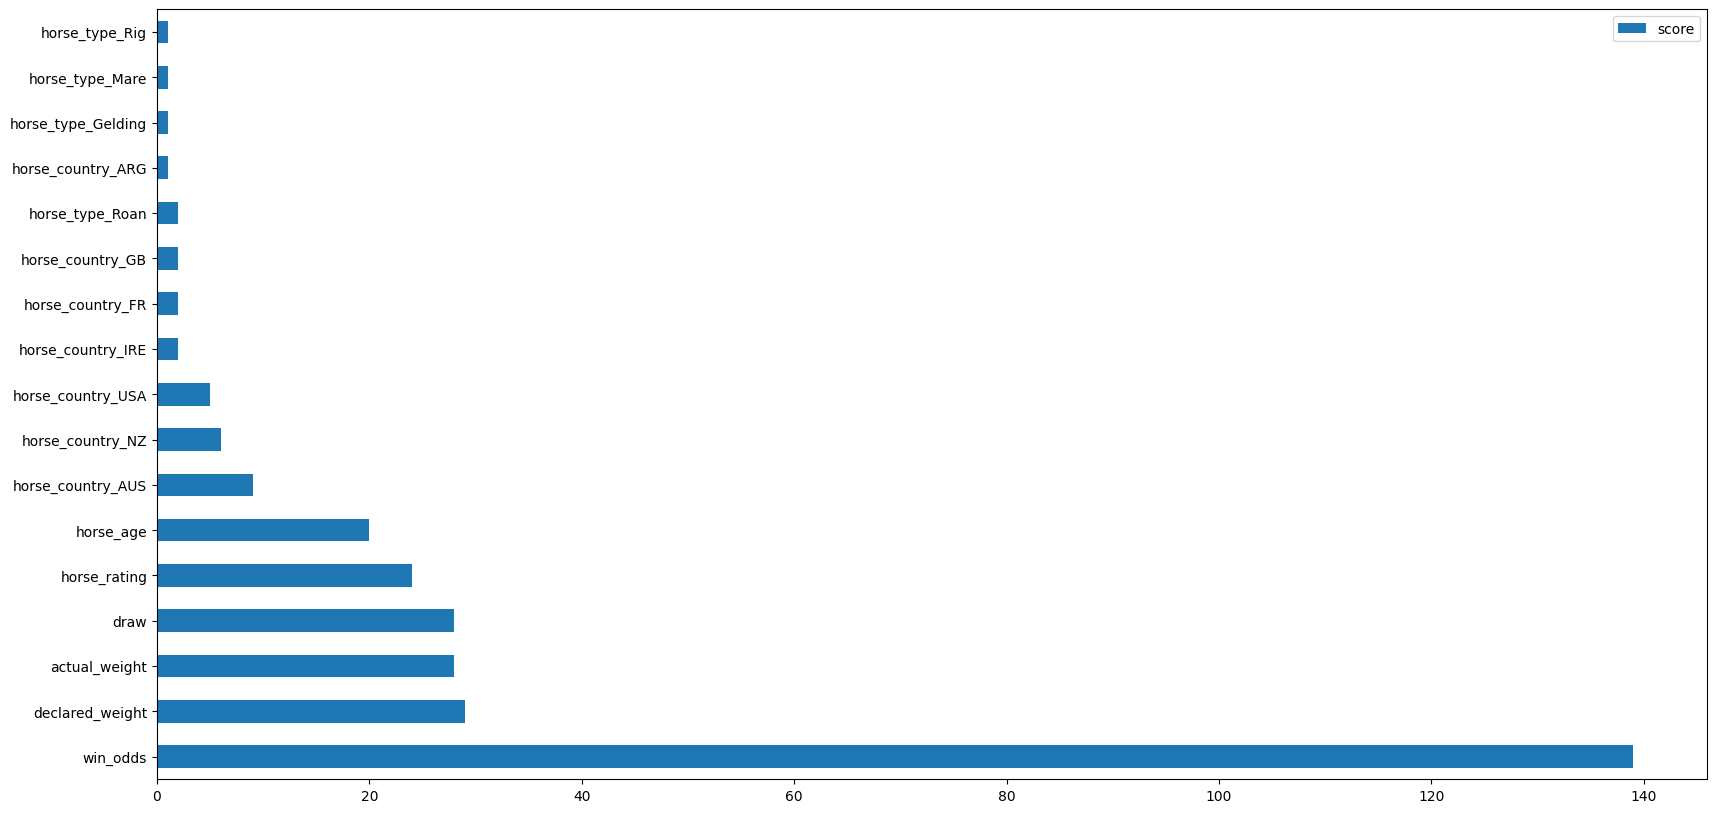

In [12]:
feature_important = xg_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

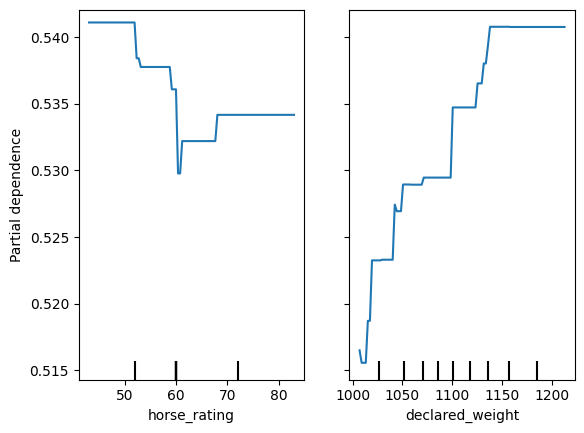

In [13]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(xg_model, X_test, features=['horse_rating', 'declared_weight'])

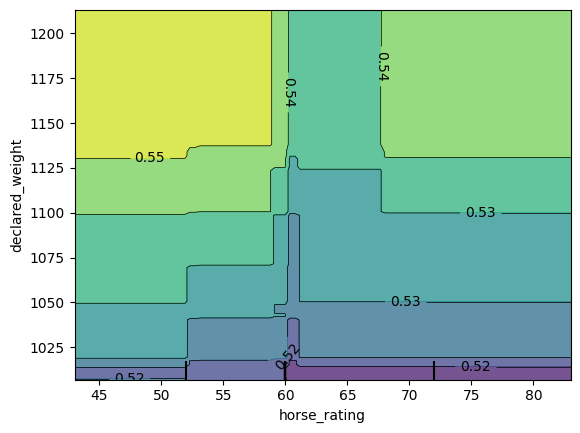

In [14]:
PartialDependenceDisplay.from_estimator(xg_model, X_test, features=[('horse_rating', 'declared_weight')])

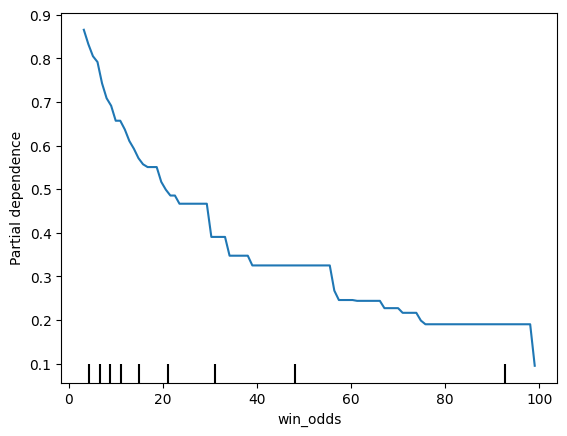

In [15]:
PartialDependenceDisplay.from_estimator(xg_model, X_test, features=['win_odds'])

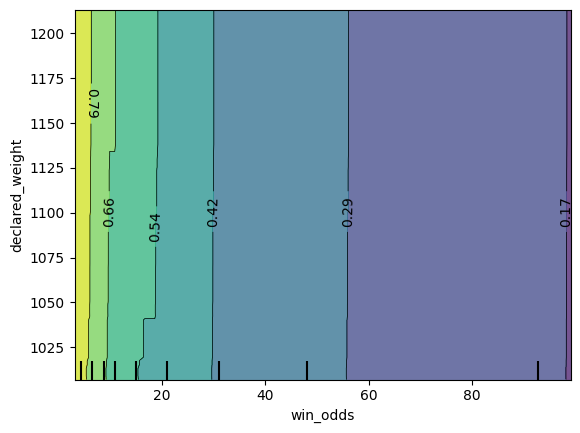

In [16]:
PartialDependenceDisplay.from_estimator(xg_model, X_test, features=[('win_odds', 'declared_weight')])